#  Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




##  Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import warnings
warnings.filterwarnings("ignore")



# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [2]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

##  Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

##   Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\risha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile(b'<.*?>')
    
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special character
    cleaned = re.sub(b'[?|!|\'|"|#]',b'',sentence)
    cleaned = re.sub(b'[.|,|)|(|\|/]',b' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'on', 'the', 'she', 'each', 'won', 'not', 'in', 'll', 'your', 'ma', "couldn't", 'against', 'once', "you'll", 'you', 'into', 'why', 'it', 'will', 'my', 'what', 'when', 'd', 'our', 'were', 'haven', 'there', 'been', 'with', 'mustn', 'yourselves', 'again', 'ourselves', 'we', 'most', 'so', 'up', 'about', 'should', 'hasn', 'through', 'more', 'these', 'shan', "haven't", 'hers', 'wouldn', 'here', 'all', 'those', 'has', 'until', 'myself', 'can', 'out', "don't", 'than', 'because', 'that', 'down', 'having', 'theirs', 'few', "shouldn't", 'which', 'such', 'do', 'did', 'had', 'they', 'doesn', 'over', 'i', "wouldn't", 'their', 'who', 'o', 'y', 've', "needn't", 'themselves', 'after', 'was', "it's", 'ours', 'an', 'me', "should've", 'he', 'weren', 't', 'if', 'no', 'while', "that'll", 'of', "wasn't", "weren't", 'other', 'isn', 'are', "she's", 'them', 'just', 'him', 'does', 'herself', "shan't", "isn't", 'from', "hadn't", 're', 'shouldn', 'very', 'for', 'this', 'wasn', "you'd", 'yours', 'below', 'too', 'm

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [14]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [15]:

# storing final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

#  Bag of Words (BoW)

In [16]:
#Sampling 60k points at random from the dataframe CleanedText
import random
sampled_points=final.sample(n=20000)


In [17]:
#time based sorting
data_sorted=sampled_points.sort_values('Time',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')
data_sorted.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
346029,374331,B00004CI84,A1OP3SQP78M1PP,James Gowen,0,0,1,1015718400,"A movie to ""literally die for!!!""",Beetlejuice is not a movie that you can't watc...,b'beetlejuic movi cant watch time one funiest ...
346053,374357,B00004CI84,A31RM5QU797HPJ,Drez,1,2,1,1024531200,"&quot;I'm the ghost with the most, babe&quot;",Simply put: Beetlejuice is the funniest comedy...,b'simpli beetlejuic funniest comedi kind sinc ...
138014,149785,B00004S1C6,A1KZ8KEBD4FONY,W. Zientek-Sico,60,61,1,1035504000,Wonderful product gives professional results,The spectra paste food colors are simply fanta...,b'spectra past food color simpli fantast provi...


1) Considering 60k points for modelling <br>
2) Top 38k points for training the model as it is time series data <br>
3) Next 9k points for cross validation <br>
4) Next 12k ponits for testing the model 

In [24]:
#Taking 60k points and splitting into train and test data
from sklearn.model_selection import train_test_split

X_train_cv, X_test, y_train_cv, y_test = train_test_split(data_sorted['CleanedText'].values,data_sorted['Score'].values,test_size=0.2,shuffle=False)

X_train,X_cv,y_train,y_cv=train_test_split(X_train_cv,y_train_cv,test_size=0.2,shuffle=False)


(12800,)


In [19]:
#Building BOW model on vocublary of training data and then transforming train, cv and test data on the built vocublary
count_vect = CountVectorizer() 
count_vect.fit(X_train)
train_bow=count_vect.transform(X_train)

cv_bow=count_vect.transform(X_cv)

test_bow=count_vect.transform(X_test)

In [20]:
print("The type and dimesions of training data are ",type(train_bow)," ",train_bow.get_shape())
print("The type and dimesions of cross validation data are ",type(cv_bow)," ",cv_bow.get_shape())
print("The type and dimesions of test data are ",type(test_bow)," ",test_bow.get_shape())


The type and dimesions of training data are  <class 'scipy.sparse.csr.csr_matrix'>   (12800, 14547)
The type and dimesions of cross validation data are  <class 'scipy.sparse.csr.csr_matrix'>   (3200, 14547)
The type and dimesions of test data are  <class 'scipy.sparse.csr.csr_matrix'>   (4000, 14547)


In [21]:
#Standardizing the train, cv and test data
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler(with_mean=False)
x_train=scaler.fit_transform(train_bow)
x_cv=scaler.fit_transform(cv_bow)
x_test=scaler.fit_transform(test_bow)

# Brute Force kNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import roc_auc_score
roc_score=[]
k=[]
for i in range(1,50,2):
    neigh=knn(n_neighbors=i,algorithm='brute')
    
    neigh.fit(x_train,y_train)
    
   # y_pred=neigh.predict(x_cv)
    y_proba=neigh.predict_proba(x_cv)[:,1]
    
    roc_area=roc_auc_score(y_cv,y_proba)
    
    k.append(i)
    roc_score.append(roc_area)
    print("The area under curve for K=",i," is ",roc_area*100,"% \n")

    
    
    

The area under curve for K= 1  is  54.90265384776507 % 

The area under curve for K= 3  is  58.86859971304092 % 

The area under curve for K= 5  is  60.23230986343263 % 

The area under curve for K= 7  is  61.209338737380094 % 

The area under curve for K= 9  is  62.145523071928274 % 

The area under curve for K= 11  is  62.58355457458842 % 

The area under curve for K= 13  is  62.82894909094716 % 

The area under curve for K= 15  is  63.18516060282352 % 

The area under curve for K= 17  is  63.610722738888214 % 

The area under curve for K= 19  is  63.44852278915839 % 

The area under curve for K= 21  is  63.37933580495162 % 

The area under curve for K= 23  is  63.70429208034854 % 

The area under curve for K= 25  is  64.01150978174354 % 

The area under curve for K= 27  is  64.25654429014284 % 

The area under curve for K= 29  is  64.40084202588916 % 

The area under curve for K= 31  is  64.35355007121612 % 

The area under curve for K= 33  is  64.68865202547023 % 

The area under c

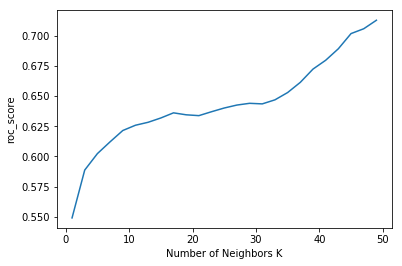

In [34]:
plt.plot(k,roc_score)
plt.xlabel('Number of Neighbors K')
plt.ylabel('roc_score')
plt.show()    
    

# Testing the model on test data

In [35]:
optimal_k = k[roc_score.index(max(roc_score))]
neigh=knn(n_neighbors=optimal_k,algorithm='brute')
    
neigh.fit(x_train,y_train)
    
y_pred=neigh.predict(x_test)
    
y_proba=neigh.predict_proba(x_test)[:,1]
roc_area=roc_auc_score(y_test,y_proba)    
    
print("The roc_score for K=",optimal_k," is ",roc_area*100,"% \n")



The roc_score for K= 49  is  70.88230101913493 % 



#Plotting the ROC Curve for test data

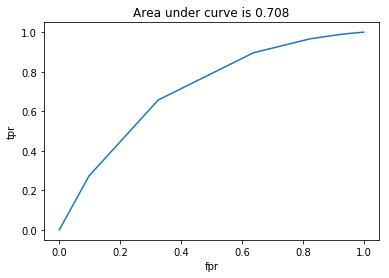

In [38]:
from sklearn import metrics
fpr,tpr,thresholds =metrics.roc_curve(y_test,y_proba,pos_label=1)
plt.plot(fpr,tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title("Area under curve is 0.708")
plt.show()  

# kNN algorithm='kd-tree' 

1. Since kd-tree accepts only dense matrix we need to convert the sparse matrix into dense matrix using truncated SVD()
2. The right no. of dimension can be found out using the elbow method

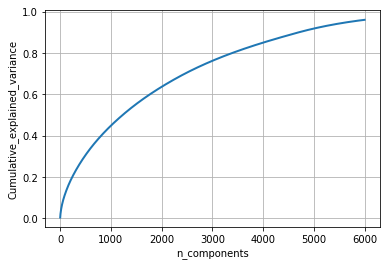

In [29]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=6000, n_iter=7, random_state=42)
svd_x_train=svd.fit_transform(x_train)
percentage_variance_explained=svd.explained_variance_ratio_

cum_var_explained=np.cumsum(percentage_variance_explained)
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()


#Considering n_components=6000 for train, cv and test data
#Now tranform cv and test data into dense matrices

In [22]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=6000, n_iter=7, random_state=42)
svd.fit(x_train)
svd_x_train=svd.transform(x_train)
svd_x_cv=svd.transform(x_cv)
svd_x_test=svd.transform(x_test)


In [23]:
print("The type and dimesions of training data are ",type(svd_x_train)," ",svd_x_train.shape)
print("The type and dimesions of cross validation data are ",type(svd_x_cv)," ",svd_x_cv.shape)
print("The type and dimesions of test data are ",type(svd_x_test)," ",svd_x_test.shape)


The type and dimesions of training data are  <class 'numpy.ndarray'>   (12800, 6000)
The type and dimesions of cross validation data are  <class 'numpy.ndarray'>   (3200, 6000)
The type and dimesions of test data are  <class 'numpy.ndarray'>   (4000, 6000)


# Using simple CV to find out the best k

In [24]:
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import roc_auc_score
roc_score=[]
k=[]
for i in range(1,30,2):
    neigh=knn(n_neighbors=i,algorithm='kd_tree')
    
    neigh.fit(svd_x_train,y_train)
    
    y_proba=neigh.predict_proba(svd_x_cv)[:,1]
    roc_area=roc_auc_score(y_cv,y_proba)    
    k.append(i)
    roc_score.append(roc_area)
    print("The area under curve for K=",i," is ",roc_area*100,"% \n")
    

    
  

The area under curve for K= 1  is  55.53385206470152 % 

The area under curve for K= 3  is  59.0422505085074 % 

The area under curve for K= 5  is  62.654872792432116 % 

The area under curve for K= 7  is  64.70336395139854 % 

The area under curve for K= 9  is  65.56933996276327 % 

The area under curve for K= 11  is  66.5258518171741 % 

The area under curve for K= 13  is  67.59079144200864 % 

The area under curve for K= 15  is  68.63686382763483 % 

The area under curve for K= 17  is  69.01831164777926 % 

The area under curve for K= 19  is  69.90934308376113 % 

The area under curve for K= 21  is  70.5293387251262 % 

The area under curve for K= 23  is  70.85310862148754 % 

The area under curve for K= 25  is  71.50148920027121 % 

The area under curve for K= 27  is  71.99005316458424 % 

The area under curve for K= 29  is  72.52835803226468 % 



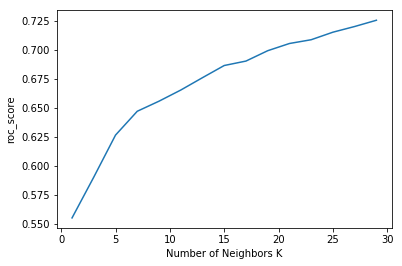

Optimal k= 29


In [25]:
plt.clf()
plt.plot(k,roc_score)
plt.xlabel('Number of Neighbors K')
plt.ylabel('roc_score')
plt.show()   
print("Optimal k=",k[roc_score.index(max(roc_score))]) 

# Testing the model on test data

In [26]:
optimal_k = k[roc_score.index(max(roc_score))]
neigh=knn(n_neighbors=optimal_k,algorithm='brute')
    
neigh.fit(x_train,y_train)
    
y_pred=neigh.predict(x_test)
    
y_proba=neigh.predict_proba(x_test)[:,1]
roc_area=roc_auc_score(y_test,y_proba)    
    
print("The roc_score for K=",optimal_k," is ",roc_area*100,"% \n")
    
    

The roc_score for K= 29  is  69.79593073593074 % 



# TF-IDF Algorithm

In [27]:
tf_idf = TfidfVectorizer(ngram_range=(1,2))
tf_idf.fit(X_train)

tf_idf_train=tf_idf.transform(X_train)

tf_idf_cv=tf_idf.transform(X_cv)

tf_idf_test=tf_idf.transform(X_test)




In [28]:
print("The type and dimesions of training data are ",type(tf_idf_train)," ",tf_idf_train.get_shape())
print("The type and dimesions of cross validation data are ",type(tf_idf_cv)," ",tf_idf_cv.get_shape())
print("The type and dimesions of test data are ",type(tf_idf_test)," ",tf_idf_test.get_shape())


The type and dimesions of training data are  <class 'scipy.sparse.csr.csr_matrix'>   (12800, 282275)
The type and dimesions of cross validation data are  <class 'scipy.sparse.csr.csr_matrix'>   (3200, 282275)
The type and dimesions of test data are  <class 'scipy.sparse.csr.csr_matrix'>   (4000, 282275)


In [29]:
#Standardizing the train, cv and test data
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler(with_mean=False)
x_train=scaler.fit_transform(tf_idf_train)
x_cv=scaler.fit_transform(tf_idf_cv)
x_test=scaler.fit_transform(tf_idf_test)


# Brute Force kNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import roc_auc_score
roc_score=[]
k=[]
for i in range(1,30,2):
    neigh=knn(n_neighbors=i,algorithm='brute')
    
    neigh.fit(x_train,y_train)
    
    #y_pred=neigh.predict(x_cv)
    
    y_proba=neigh.predict_proba(x_cv)[:,1]
    
    roc_area=roc_auc_score(y_cv,y_proba)
    
    k.append(i)
    roc_score.append(roc_area)
    print("The area under curve for K=",i," is ",roc_area*100,"% \n")


The area under curve for K= 1  is  50.0 % 

The area under curve for K= 3  is  50.0 % 

The area under curve for K= 5  is  50.0886524822695 % 

The area under curve for K= 7  is  50.0886524822695 % 

The area under curve for K= 9  is  50.177304964539005 % 

The area under curve for K= 11  is  50.13936869746769 % 

The area under curve for K= 13  is  50.15214864559455 % 

The area under curve for K= 15  is  50.15214864559455 % 

The area under curve for K= 17  is  50.18389672725707 % 

The area under curve for K= 19  is  50.3042972911891 % 

The area under curve for K= 21  is  50.27914097224464 % 

The area under curve for K= 23  is  51.819191984416534 % 

The area under curve for K= 25  is  51.44309156361992 % 

The area under curve for K= 27  is  50.855583895651044 % 

The area under curve for K= 29  is  53.98478782595595 % 



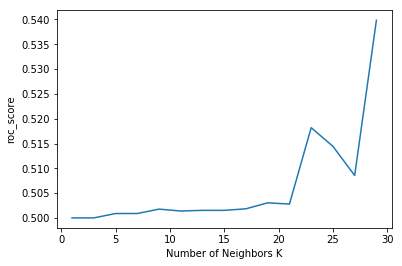

In [31]:
plt.clf()
plt.plot(k,roc_score)
plt.xlabel('Number of Neighbors K')
plt.ylabel('roc_score')
plt.show()    
    

# Testing the model on test data

In [32]:
optimal_k = k[roc_score.index(max(roc_score))]
neigh=knn(n_neighbors=optimal_k,algorithm='brute')
    
neigh.fit(x_train,y_train)
    
y_pred=neigh.predict(x_test)
    
y_proba=neigh.predict_proba(x_test)[:,1]
roc_area=roc_auc_score(y_test,y_proba)    
    
print("The roc_score for K=",optimal_k," is ",roc_area*100,"% \n")
    

The roc_score for K= 29  is  54.913419913419915 % 



# kNN algorithm='kd-tree' on tf-idf

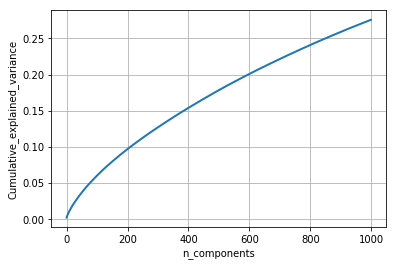

In [33]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)
svd_x_train=svd.fit_transform(x_train)
percentage_variance_explained=svd.explained_variance_ratio_

cum_var_explained=np.cumsum(percentage_variance_explained)
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()


In [34]:
# from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)
svd.fit(x_train)
svd_x_train=svd.transform(x_train)
svd_x_cv=svd.transform(x_cv)
svd_x_test=svd.transform(x_test)

In [35]:
print("The type and dimesions of training data are ",type(svd_x_train)," ",svd_x_train.shape)
print("The type and dimesions of cross validation data are ",type(svd_x_cv)," ",svd_x_cv.shape)
print("The type and dimesions of test data are ",type(svd_x_test)," ",svd_x_test.shape)

The type and dimesions of training data are  <class 'numpy.ndarray'>   (12800, 1000)
The type and dimesions of cross validation data are  <class 'numpy.ndarray'>   (3200, 1000)
The type and dimesions of test data are  <class 'numpy.ndarray'>   (4000, 1000)


# Using simple CV ro deteremine the right k for knn on tf-idf

In [36]:
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import roc_auc_score
roc_score=[]
k=[]
for i in range(1,50,2):
    neigh=knn(n_neighbors=i,algorithm='kd_tree')
    
    neigh.fit(svd_x_train,y_train)
    
    y_proba=neigh.predict_proba(svd_x_cv)[:,1]
    roc_area=roc_auc_score(y_cv,y_proba)    
    k.append(i)
    roc_score.append(roc_area)
    print("The area under curve for K=",i," is ",roc_area*100,"% \n")

The area under curve for K= 1  is  52.500699534002734 % 

The area under curve for K= 3  is  54.19478255254576 % 

The area under curve for K= 5  is  54.48643442137775 % 

The area under curve for K= 7  is  55.78551614847341 % 

The area under curve for K= 9  is  58.00882354523833 % 

The area under curve for K= 11  is  58.565692969145175 % 

The area under curve for K= 13  is  58.49708482656938 % 

The area under curve for K= 15  is  59.32011348593937 % 

The area under curve for K= 17  is  59.943203220008826 % 

The area under curve for K= 19  is  59.77699663147473 % 

The area under curve for K= 21  is  60.20351058448756 % 

The area under curve for K= 23  is  60.425612630355474 % 

The area under curve for K= 25  is  60.125115692162 % 

The area under curve for K= 27  is  59.60927662803087 % 

The area under curve for K= 29  is  59.24474542343331 % 

The area under curve for K= 31  is  58.951142930939845 % 

The area under curve for K= 33  is  59.043091294568384 % 

The area under 

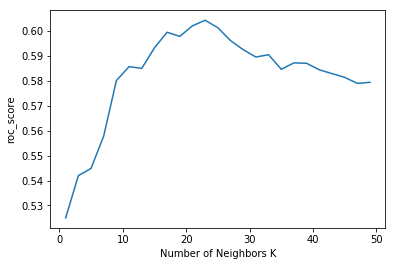

Optimal k= 23


In [37]:
plt.clf()
plt.plot(k,roc_score)
plt.xlabel('Number of Neighbors K')
plt.ylabel('roc_score')
plt.show()   
print("Optimal k=",k[roc_score.index(max(roc_score))]) 

# Testing the model on test data

In [38]:
from sklearn.neighbors import KNeighborsClassifier as knn
optimal_k = k[roc_score.index(max(roc_score))]
neigh=knn(n_neighbors=optimal_k,algorithm='kd_tree')
    
neigh.fit(svd_x_train,y_train)
    
y_proba=neigh.predict_proba(svd_x_test)[:,1]
roc_area=roc_auc_score(y_test,y_proba)    
    
print("The roc_score for K=",optimal_k," is ",roc_area*100,"% \n")
    
    

The roc_score for K= 23  is  57.9003896103896 % 

